In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.stats import beta
import timeit
from scipy.interpolate import interp1d
import scipy.stats as st

# The true distribution
We take the true distribution of $y$ to be $\mathcal{Beta}(3,3)$ drawn on $[-1,1]$. i.e. we have unormalized density
<br>
<center> $(1+y)^2(1-y)^2$

We seek to find $x^*$ such that it solves $\min_x E[c(x,y)]$ where
<br>
<center>$c(x,y) = 3x^2 + 6xy^2 - 2x^2y - 7xy$.

This can be solved analytically, whereby $x$ is minimised at $-1/7$ = -0.14286.

In [2]:
# the cost function we would like to minimise
def f(x,y):
    return np.mean(3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y,axis=0)

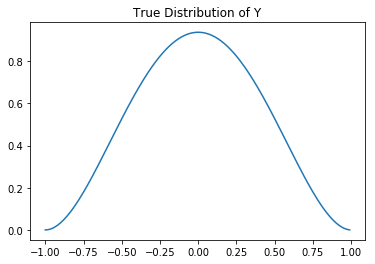

In [3]:
# Define the true distribution
Y = beta(a = 3,b=3,loc=-1,scale=2)

# plot the pdf within the range
x = np.arange (-1, 1, 0.01)
z = Y.pdf(x)
plt.plot(x,z)
plt.title("True Distribution of Y")

In [4]:
# Some experimental hyper parameters

# number of iterations to perform each experiment
n_iter = 1000

# number of samples for each experiment
# we use 50, 100, 150...., 5000 samples
N = [50,200, 800,3200]

## Sample Average Approximation

To perform SSA, we take sample of $N$ points, $S$, drawn from $Y$ with the given distribution. 
we then solve <br> <center>$\min_x (1/N)\Sigma_i^N c(x,\zeta_i)$

In [5]:
start_time = timeit.default_timer()

SSA_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])
        # minimise the cost function given the samples, with initial starting point of 0
        res = minimize(f,0.0,args=(S))

        SSA_results[k,j] = res.x
        
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

This has taken 1.85 seconds


# Maximum likelihood

Instead of using samples directly, we fit a parameterised distribution to the samples. We then sample from the learned distribution and perform SSA.

In this case, we fit a Beta distribution

In [6]:
# no of samples to draw from the learned distribution
N_SAMPLES = 10000

In [7]:
start_time = timeit.default_timer()
MLE_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])

        # fit a beta distribution using MLE
        a1, b1, loc1, scale1 = beta.fit(S)

        # now sample from that beta distribution
        MC_samples = beta(a = a1,b=b1,loc=loc1,scale=scale1).rvs(N_SAMPLES)
        
        # minimise the cost function
        res = minimize(f,0.0,args=(MC_samples))
        
        MLE_results[k,j] = res.x
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

/usr/local/lib/python2.7/dist-packages/scipy/stats/_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


This has taken 99.42 seconds


We plot the average x value obtained across the number of iterations performed for each sample set. The deviation from $x^*=-1/7$ is shown below.

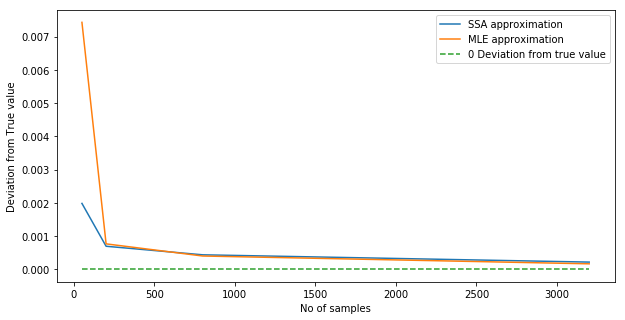

In [27]:
plt.figure(figsize=(10,5))
plt.plot(N,abs(np.mean(SSA_results,axis=0)+1.0/7),label='SSA approximation')
plt.plot(N,abs(np.mean(MLE_results,axis=0)+1.0/7),label='MLE approximation')
plt.plot(N,[0]*len(N),'--',label='0 Deviation from true value')
plt.xlabel('No of samples')
plt.ylabel('Deviation from True value')
plt.legend()

It seems like there is big difference at $N=50$. So lets ignore that data point and plot the rest.

Plot suggests that MLE estimation performs better than SSA at $N\rightarrow \infty$

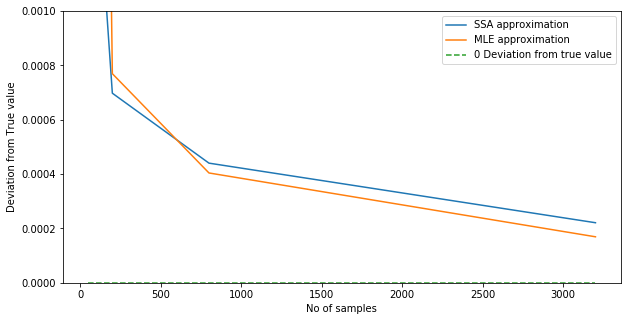

In [28]:
plt.figure(figsize=(10,5))
plt.plot(N,abs(np.mean(SSA_results,axis=0)+1.0/7),label='SSA approximation')
plt.plot(N,abs(np.mean(MLE_results,axis=0)+1.0/7),label='MLE approximation')
plt.plot(N,[0]*len(N),'--',label='0 Deviation from true value')
plt.xlabel('No of samples')
plt.ylabel('Deviation from True value')
plt.ylim(0,0.001)
plt.legend()

We also plot the standard deviation of the results. As we get more samples of $y$, the variance of the approximation to $x^*$ decreases.

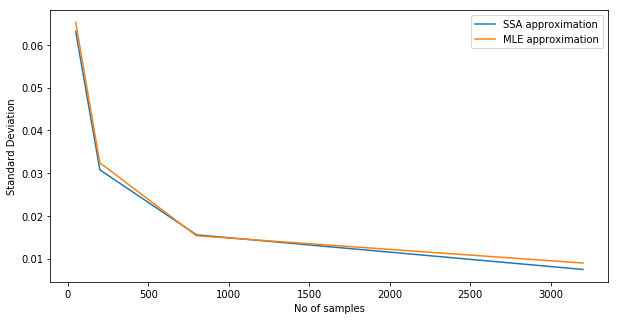

In [29]:
plt.figure(figsize=(10,5))
plt.plot(N,np.std(SSA_results,axis=0),label='SSA approximation')
plt.plot(N,np.std(MLE_results,axis=0),label='MLE approximation')
plt.xlabel('No of samples')
plt.ylabel('Standard Deviation')
plt.legend()

## We fit a linear piecewise distribution

Some initial tests.

To make things simple, I've assumed that the mode occurs at the median. Also, the pdf at the end points extends at the rate of the maximum slope value.

In [112]:
# obtain the samples
S = Y.rvs(201)
sorted_S = np.sort(S)
initial_p = np.array([1.0/len(S)]*len(S))

# maximum slope possible for the pdf
max_slope = 5

# for simplicity, we pick the median to be the mode
mode_index = len(initial_p)/2

In [113]:
def compute_epsilon(p1,p0,epsilon1,max_slope):
    return (epsilon1 - (p1-p0)/max_slope)

In [114]:
# the likelihood function
def linear_piecewise_loglikelihood(p):
    return -np.sum(np.log(p))

In [115]:
# the constraint that ensures area of pdf sums to 1
def constraint1(p,x):
    mode_index = len(p)/2
    area = 0
    # find the area of the first triangle where p0 = 0
    area += p[0]**2/(2*max_slope)
    for i in range(mode_index):
        if np.isclose(p[i+1],p[i]):
            # if the pdf is flat at the point
            # the area is just a rectangle
            area+= p[i]*(x[i+1]-x[i])

        else:
            # otherwise, the area is a triangle +  a rectangle components
            area += (p[i+1]-p[i])*(x[i+1]-x[i])/2 + p[i]*(x[i+1]-x[i])


    for i in range(mode_index+1,len(x)):
        if np.isclose(p[i-1],p[i]):
            area+= p[i]*(x[i]-x[i-1])
        else:
            # otherwise, the area is a triangle +  a rectangle components
            area += (p[i-1]-p[i])*(x[i]-x[i-1])/2 + p[i]*(x[i]-x[i-1])
    area += p[-1]**2/(2*max_slope)
    return (area - 1.0)

In [116]:
# create the set of constraints that the slope between neighbouring poitns
# is between 0 and max_slope
flist = []
slope_flist = []


for i in xrange(mode_index):
    # constraint that makes the next point greater than it
    def funcC(j):
        def func(p): return p[j+1] -p[j]
        return func
    flist.append(funcC(i))
    
    # positive slope constraint
    def funcC(j):
        def func(p,x): return max_slope-(p[j+1] -p[j])/(x[j+1] -x[j])
        return func
    slope_flist.append(funcC(i))
    
for i in xrange(mode_index,len(sorted_S)-1):
    def funcC(j):
        def func(p): return p[j]-p[j+1]
        return func
    flist.append(funcC(i))
    
    # negative slope constraint
    def funcC(j):
        def func(p,x): return max_slope+(p[j] - p[j+1])/(x[j] - x[j+1])
        return func
    slope_flist.append(funcC(i))

In [117]:
constraints= []
for i in range(0, len(flist)):
    constraints.append({'type': 'ineq', 'fun' : flist[i]})
    constraints.append({'type': 'ineq', 'fun' : slope_flist[i],'args':[sorted_S]})
constraints.append({'type':'eq','fun':constraint1,'args':[sorted_S]})

In [118]:
# the bounds for p is (0, inf)
b =[]
for i in range(len(sorted_S)):
    b.append((0,None))

In [119]:
test = minimize(linear_piecewise_loglikelihood,initial_p,bounds=b,constraints=constraints,method='SLSQP')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


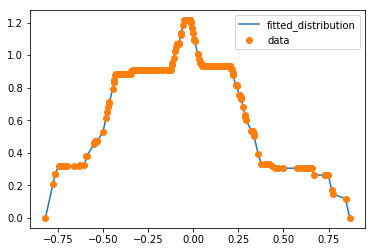

In [120]:
# plot the learned distribution including the end points
epsilon0 = compute_epsilon(test.x[0],0,sorted_S[0],max_slope)
epislon_end = compute_epsilon(test.x[-1],0,sorted_S[-1],-max_slope)
temp = np.pad(test.x,(1,1),mode='constant',constant_values=0)
temp_x = np.pad(sorted_S,(1,1),mode='constant',constant_values=(epsilon0,epislon_end))
plt.plot(temp_x,temp,label='fitted_distribution')
plt.plot(temp_x,temp,'o',label='data')
plt.legend(loc='best')

In [121]:
# create a linear function by interpolating the p points
# the interpolation will enable use to use scipy to sample from the distribution
interpolated_pdf = interp1d(temp_x, temp)

# we will then create the inverse cdf which we will use to sample from
new_x  = np.linspace(temp_x[0],temp_x[-1],1000,endpoint=True)
new_y = interpolated_pdf(new_x)
# Compute the CDF
CY = np.cumsum(new_y*(new_x[1]-new_x[0]))

# find the inverse CDF
inverse_interpolated_cdf = interp1d(CY, new_x)

We compare a histogram of obtained samples from the fitted distribution against the pdf of the distribution, just to make sure that I'm sampling correctly.

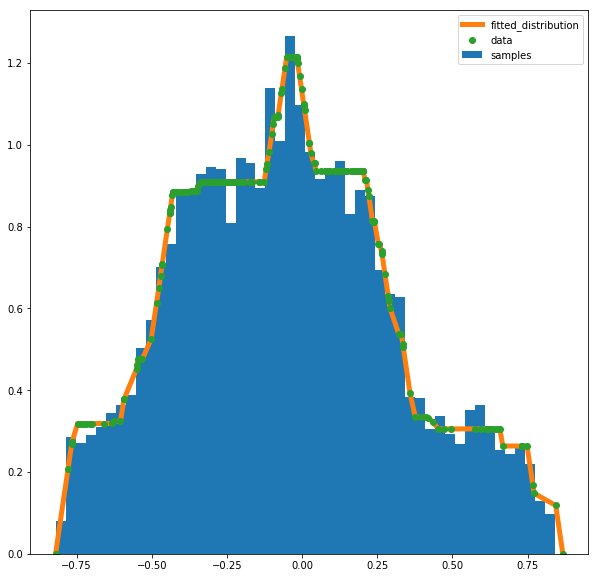

In [122]:
r = np.random.uniform(size=10000)
result = inverse_interpolated_cdf(r)
plt.figure(figsize=(10,10))
#plt.subplot(211)
plt.hist(result,bins=50,normed=True,label='samples')
#plt.subplot(212)
plt.plot(temp_x,interpolated_pdf(temp_x),label='fitted_distribution', linewidth=5)
plt.plot(temp_x,temp,'o',label='data')
plt.legend()

### alternate way of sampling

Below is an alternate way of sampling, by creating a distribution object using scipy based on the linear interpolation of the pdf. Its not used anymore, because its pretty slow and takes a lot more RAM to gather samples. I'm guessing its because scipy performs numeric integration at every sampling step rather than immediately finding the inverse CDF and storing that for sampling. 

It takes 83 seconds to sample 500 times from the fitted distribution

We compare a histogram of obtained samples from the fitted distribution against the pdf of the distribution, just to make sure that scipy is doing its sampling somewhat correctly... 

In [34]:
# the constraint that ensures area of pdf sums to 1
def _constraint1(p,x,max_slope):
        mode_index = len(p)/2
        area = 0
        # find the area of the first triangle where p0 = 0
        area += p[0]**2/(2*max_slope)
        for i in range(mode_index):
            
            if np.isclose(p[i+1],p[i]):
                # if the pdf is flat at the point
                # the area is just a rectangle
                area+= p[i]*(x[i+1]-x[i])

            else:
                # otherwise, the area is a triangle +  a rectangle components
                area += (p[i+1]-p[i])*(x[i+1]-x[i])/2 + p[i]*(x[i+1]-x[i])


        for i in range(mode_index+1,len(x)):
            if np.isclose(p[i-1],p[i]):
                area+= p[i]*(x[i]-x[i-1])
            else:
                # otherwise, the area is a triangle +  a rectangle components
                area += (p[i-1]-p[i])*(x[i]-x[i-1])/2 + p[i]*(x[i]-x[i-1])
        area += p[-1]**2/(2*max_slope)
        return (area - 1.0)

def _create_constraints(mode_index,max_slope,n_samples):
        # create the set of constraints that the slope between neighbouring poitns
        # is between 0 and max_slope
        flist = []
        slope_flist = []

        for i in xrange(mode_index):
            # constraint that makes the next point greater than it
            def funcC(j):
                def func(p): return p[j+1] -p[j]
                return func
            flist.append(funcC(i))

            # positive slope constraint
            def funcC(j):
                def func(p,x): return max_slope-(p[j+1] -p[j])/(x[j+1] -x[j])
                return func
            slope_flist.append(funcC(i))

        for i in xrange(mode_index,n_samples-1):
            def funcC(j):
                def func(p): return p[j]-p[j+1]
                return func
            flist.append(funcC(i))

            # negative slope constraint
            def funcC(j):
                def func(p,x): return max_slope+(p[j] - p[j+1])/(x[j] - x[j+1])
                return func
            slope_flist.append(funcC(i))
            
        return flist,slope_flist

def _compute_epsilon(p1,p0,epsilon1,max_slope):
    return (epsilon1 - (p1-p0)/max_slope)
    
# the likelihood function
def _linear_piecewise_loglikelihood(p):
    return -np.sum(np.log(p + np.finfo(np.float32).eps))

class Linear_Piecewise():
    def __init__(self):
        return
    
    def fit(self, x, max_slope, **kwargs):
        # maximum slope for the distribution
        self.max_slope = max_slope

        sorted_x = np.sort(x)
        # possibly start with a good initial value of p based of guassian?
        initial_p = st.norm.pdf(sorted_x,loc=np.mean(sorted_x),scale=np.std(sorted_x))
        #initial_p = np.array([1.0/len(x)]*len(x))
        
        # for simplicity, we pick the median to be the mode
        mode_index = len(initial_p)/2

        flist,slope_flist = _create_constraints(mode_index,self.max_slope,len(sorted_x))
        

        # store the constraints in a dict to be used for scipy minimise    
        constraints= []
        for i in range(0, len(flist)):
            constraints.append({'type': 'ineq', 'fun' : flist[i]})
            constraints.append({'type': 'ineq', 'fun' : slope_flist[i],'args':[sorted_x]})
        constraints.append({'type':'eq','fun':_constraint1,'args':[sorted_x,self.max_slope]})

        # the bounds for p is (0, inf)
        b =[]
        for i in range(len(sorted_x)):
            b.append((0,None))
            

        result = minimize(_linear_piecewise_loglikelihood,
                          initial_p,bounds=b,
                          constraints=constraints,
                          method='SLSQP',
                          **kwargs)
                          #method='SLSQP',
                          #options=kwargs['options'],
                          #tol=kwargs['tol'])
        
        # addthe end points
        epsilon0 = _compute_epsilon(result.x[0],0,sorted_x[0],self.max_slope)
        epislon_end = _compute_epsilon(result.x[-1],0,sorted_x[-1],-self.max_slope)
        
        temp = np.pad(result.x,(1,1),mode='constant',constant_values=0)
        temp_x = np.pad(sorted_x,(1,1),mode='constant',constant_values=(epsilon0,epislon_end))

        # find the support of the distribution
        self.x_min = temp_x[0]
        self.x_max = temp_x[-1]
        
        self.x = temp_x
        self.y = temp
        
        # create a linear function by interpolating the p points
        self.pdf = interp1d(temp_x, temp)
        
        
        # we will then create the inverse cdf which we will use to sample from
        new_x  = np.linspace(self.x_min,self.x_max,2000,endpoint=True)
        new_y = self.pdf(new_x)
        
        # Compute the CDF
        CY = np.cumsum(new_y*(new_x[1]-new_x[0]))
        self.temp = new_y
        self.CY =  CY

        # find the inverse CDF
        self.inverse_cdf = interp1d(CY,new_x)
    
    def pdf(self,x):
        return self.pdf(x)
    
    def rvs(self,size=1):
        r = np.random.uniform(size=size)
        return self.inverse_cdf(r)

In [35]:
S = Y.rvs(201)
start_time = timeit.default_timer()
h = Linear_Piecewise()
h.fit(S, 2.0,options={'maxiter': 100})
print(timeit.default_timer() - start_time)

112.171034098


Using max_iter = 100, it takes on average 5 seconds for 51 samples, 2 minutes for 201 samples...

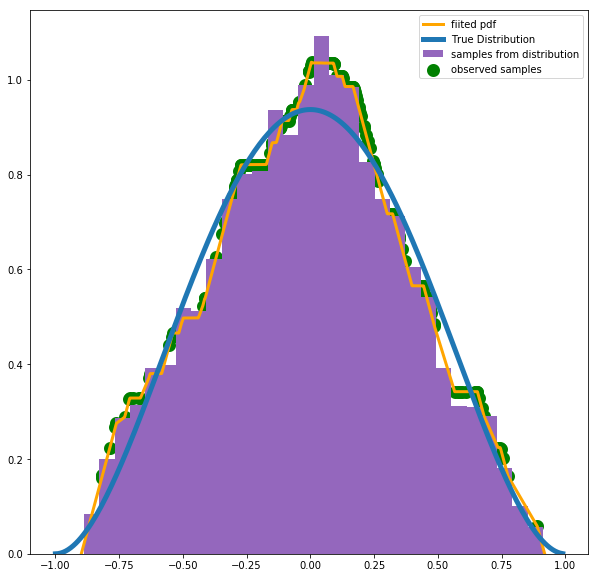

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(S,h.pdf(S),label='observed samples' ,linewidth=7,color='g')
plt.hist(h.rvs(10000),bins=30,normed=True,label='samples from distribution',color='C4')


new_x = np.linspace(h.x_min,h.x_max,1000)
plt.plot(new_x, h.pdf(new_x),color='orange', label='fiited pdf',linewidth=3)
#plt.plot(temp_x,temp,'o',label='data')
# plot the pdf within the range
x = np.arange (-1, 1, 0.01)
z = Y.pdf(x)
plt.plot(x,z,linewidth=5, label='True Distribution')
plt.legend()

We test when the the maximum slope has been under specified.

11.3742001057


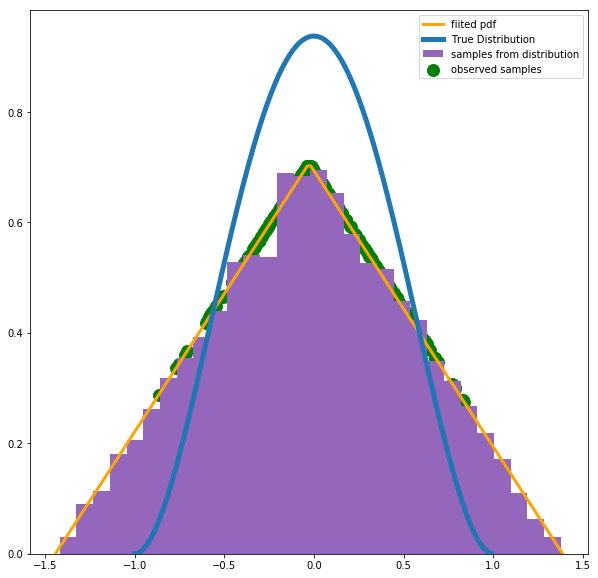

In [42]:
h = Linear_Piecewise()
S = Y.rvs(201)
start_time = timeit.default_timer()
h.fit(S, 0.5,options={'maxiter': 100})
print(timeit.default_timer() - start_time)

plt.figure(figsize=(10,10))
plt.scatter(S,h.pdf(S),label='observed samples' ,linewidth=7,color='g')
plt.hist(h.rvs(10000),bins=30,normed=True,label='samples from distribution',color='C4')


new_x = np.linspace(h.x_min,h.x_max,1000)
plt.plot(new_x, h.pdf(new_x),color='orange', label='fiited pdf',linewidth=3)
#plt.plot(temp_x,temp,'o',label='data')
# plot the pdf within the range
x = np.arange (-1, 1, 0.01)
z = Y.pdf(x)
plt.plot(x,z,linewidth=5, label='True Distribution')
plt.legend()

# Begin the experiments

In [65]:
# number of iterations to perform each experiment
n_iter = 10

# number of samples for each experiment
N = [801]

# maximum slope possible for the pdf
max_slope = 10

In [66]:
start_time = timeit.default_timer()
linear_MLE_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])

        # fit a linearpiece distribution using MLE
        h = Linear_Piecewise()
        
        h.fit(S, max_slope,options={'maxiter': 100})

        # now sample from that beta distribution, obtain 5000 samples
        MC_samples = h.rvs(10000)
        
        # minimise the cost function
        res = minimize(f,0,args=(MC_samples))
        
        linear_MLE_results[k,j] = res.x
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

KeyboardInterrupt: 

In [60]:
np.savetxt("Linear_MLE_results_slope10.csv", linear_MLE_results, delimiter=",",header='N=50,N=200',fmt='%.4f')

In [61]:
SSA_results = np.loadtxt("SSA_results.csv", delimiter=",",skiprows=1)
MLE_results = np.loadtxt("Beta_MLE_results.csv",delimiter=",",skiprows=1)

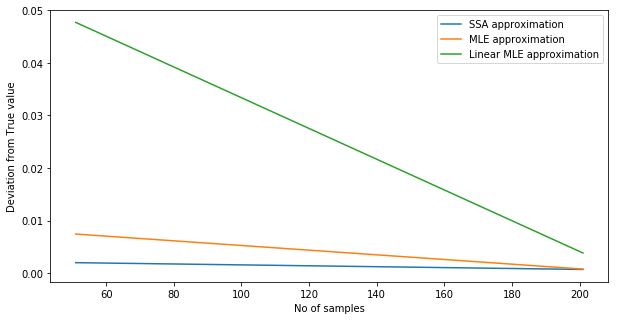

In [63]:
plt.figure(figsize=(10,5))
plt.plot(N,abs(np.mean(SSA_results[:,:2],axis=0)+1.0/7),label='SSA approximation')
plt.plot(N,abs(np.mean(MLE_results[:,:2],axis=0)+1.0/7),label='MLE approximation')
plt.plot(N,np.mean(linear_MLE_results,axis=0)+1.0/7,label='Linear MLE approximation')
plt.xlabel('No of samples')
plt.ylabel('Deviation from True value')
plt.legend()

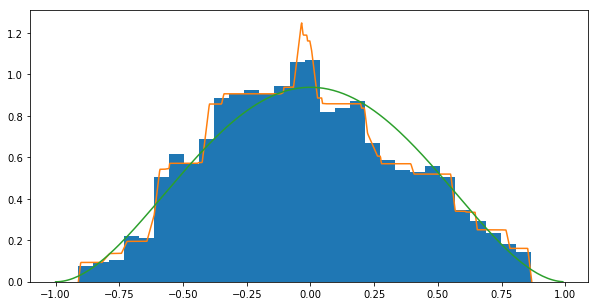

In [64]:
# plot the learned distribution again
plt.figure(figsize=(10,5))
plt.hist(MC_samples,bins=30,normed=True)
new_x = np.linspace(h.x_min, h.x_max,1000)
plt.plot(new_x,h.pdf(new_x))
# plot the pdf within the range
x = np.arange (-1, 1, 0.01)
z = Y.pdf(x)
plt.plot(x,z)